# Table of contents
1. [Proyect Overview](#introduction)
2. [Import Libraries and Functions](#paragraph1)
3. [Clean and Merge Dataframes](#paragraph2)
    1. [Dataframe 1: Standard Stats](#subparagraph1)
    2. [Dataframe 2: Latest Salary](#subparagraph2)
    3. [Dataframe 3: Advanced GK stats](#subparagraph3)
    4. [Dataframe 4: Advanced Goal and Shot Creation Stats](#subparagraph4)
    5. [Dataframe 5: Pass Types](#subparagraph5)
    6. [Dataframe 6: Shooting Stats](#subparagraph6)
    7. [Dataframe 7: Defensive Actions Stats](#subparagraph7)
    8. [Dataframe 8: Goalkeeper Stats](#subparagraph8)
    9. [Dataframe 9: Miscelleanous Stats](#subparagraph9)
    10. [Dataframe 10: Passing Stats](#subparagraph10)
    11. [Dataframe 11: Playing Time Stats](#subparagraph11)
    12. [Dataframe 12: Possession Stats](#subparagraph12)
    13. [Dataframe 13: Team Wages](#subparagraph13)
    14. [Dataframe 14: Standard Stats 2020, 2021, 2022](#subparagraph14)    
4. [EDA of Combined Dataframe](#paragraph3)
    1. [Players: Drop NaNs](#subparagraph1)
    2. [Nations: Top 10 and OHE](#subparagraph2)
    3. [Postions: Nulls, NaNs and OHE](#subparagraph3)
    4. [Squad: NaNs and Grouping](#subparagraph4)
    5. [Competition: NaNs and OHE](#subparagraph5)
    6. [Team Wages: NaNs and Encode](#subparagraph6)
5. [Baselines and Feature Intercorrelation](#paragraph4)
    1. [Regressor Baseline](#subparagraph1)
    2. [Classifier Baseline](#subparagraph2)
6. [Sal 17 Specific Modeling](#paragraph5)

<a id="introduction"></a>
## Proyect Overview

Analysis of the Five Big European Football Leagues to determine if player stats can be used to predict wages in the current year, three successive years and also whether a player will still be active three and five years years hence. 

According to a 2016 FIFPro study, the average global length of contracts is 22.6 months and for players earning over $100,000 that number goes up to approximately 32 months. The average length of contract in the data included in the Capology scrape is 2.65 years therefore a three year salary prediction seems appropriately interesting for the scope of this study therefore a starting point of 2017 was preferred over 2016 so as to be as current as possible whilst avoiding Covid related anomalies in contract restructuring.

Whilst the average contract in the dataset is under three years, the big five year contracts make the headlines especially for aging stars. A five year prediction as to whether players remain in the league will also form a part of this study.

The probative value of this study hopefully also allow us to identify players that are under and overvalued as well determine the return on investment on above average length renewal contracts.

## Import Libraries and Functions <a id="paragraph1"></a>
These are the libraries and functions imported in this notebook. Tested in Python 3.10.6.

In [2]:
import pandas as pd
from pandas import MultiIndex, Int64Index, Int16Dtype
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import plotly.graph_objects as go

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler

from sklearn.impute import KNNImputer, SimpleImputer

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, HalvingGridSearchCV
from sklearn.model_selection import KFold

import lightgbm as lgb
import xgboost

import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, StackingClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.inspection import permutation_importance

import eli5
import pickle

import warnings
warnings.filterwarnings("ignore")

/var/folders/lg/qr9nrlc51t70zzlkgwfbxvsm0000gn/T/ipykernel_20757/3171228524.py:2: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index, Int16Dtype
/Users/nickkempe/opt/anaconda3/envs/oct_env/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
# %load functions.py
def compileNANcols(DF):
    global NANlist
    NANlist = []
    NANlist = list(DF.columns[DF.isnull().any()])
    return NANlist

def imputeNANs(DF, col):
    X = DF[col].values.reshape(-1,1)
    imputer = KNNImputer(
            missing_values = np.nan,
            n_neighbors=3, 
            copy=False
            )
    imputer.fit(X)
    Xtrans = imputer.transform(X)
    DF[col] = Xtrans.ravel().tolist()

def cleanupDF(DF):    
    compileNANcols(DF)
    for col in NANlist:
        imputeNANs(DF, col)

def save_results(model, param_notes):
    models_summary.loc[len(models_summary)] = [model, model.score(X_test, y_test), f1_score(y_test), model.predict(y_test), param_notes]

## Clean and Merge Dataframes <a id="paragraph2"></a>
15 dataframes are to be imported, cleaned and merged. Baseline player stats from the Big 5 have been imported from FBref.com. Salary information is from Capology.com thanks to a an engineered scrape by GitHub user eddwebster.

### Dataframe 1: Standard Player Stats <a id="subparagraph1"></a>
Full basic stats of all players in the Big 5 leagues in 2017/18 season (herein 2017 season). 35 features are included in the original file. Of the 2691 rows (2560 unique players), 131 players are represented twice due to midseason transfers (approx. 5%). As these players stats would need to be merged correctly across the 15 dataframes' approximately 400 columns with some data dropped or augmented (team), some averaged (xAG) and some summed (goals), due to proyect time constraints all players listed twice will be removed completely. The study will therefore focus on players who in theory played the entire 2017 season with the same team. This 2429 player list from Dataframe 1 will be the unique id used when merging in the remaining dataframes.

https://fbref.com/en/comps/Big5/2017-2018/stats/players/2017-2018-Big-5-European-Leagues-Stats

In [4]:
df1 = pd.read_csv("../data/raw/fut2017standardstats.txt", header=1)
df1.head(3)

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,...,npxG,xAG,npxG+xAG,xG.1,xAG.1,xG+xAG,npxG.1,npxG+xAG.1,Matches,-9999
0,1,Patrick van Aanholt,nl NED,DF,Crystal Palace,eng Premier League,26.0,1990.0,28,25,...,3.1,2.1,5.2,0.13,0.09,0.21,0.13,0.21,Matches,5f09991f
1,2,Rolando Aarons,eng ENG,MFFW,Newcastle Utd,eng Premier League,21.0,1995.0,4,1,...,0.1,0.0,0.1,0.04,0.00,0.04,0.04,0.04,Matches,c5942695
2,3,Rolando Aarons,eng ENG,MFFW,Hellas Verona,it Serie A,21.0,1995.0,11,6,...,0.2,0.2,0.3,0.03,0.03,0.06,0.03,0.06,Matches,c5942695


In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2691 entries, 0 to 2690
Data columns (total 35 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Rk          2691 non-null   int64  
 1   Player      2691 non-null   object 
 2   Nation      2690 non-null   object 
 3   Pos         2690 non-null   object 
 4   Squad       2691 non-null   object 
 5   Comp        2691 non-null   object 
 6   Age         2690 non-null   float64
 7   Born        2690 non-null   float64
 8   MP          2691 non-null   int64  
 9   Starts      2691 non-null   int64  
 10  Min         2691 non-null   int64  
 11  90s         2691 non-null   float64
 12  Gls         2691 non-null   int64  
 13  Ast         2691 non-null   int64  
 14  G-PK        2691 non-null   int64  
 15  PK          2691 non-null   int64  
 16  PKatt       2691 non-null   int64  
 17  CrdY        2691 non-null   int64  
 18  CrdR        2691 non-null   int64  
 19  Gls.1       2691 non-null  

In [6]:
transfers = list(df1[df1.duplicated(['Player'])]['Player'].values)
print(len(df1))
for player in transfers:
    df1.drop(df1.loc[df1['Player']==player].index, inplace=True)
len(df1)

2691


2429

In [7]:
df1.drop('Rk', axis=1, inplace=True)
df1.drop("-9999", axis=1, inplace=True)

After final merge, nation, position and competion will be encoded.  It is unclear from the glossary whether a players' position listed as FWMF or MFFW is a complete redundancy or whether it means a player with FWMF played primarily as a FW. They will be combined for encoding.

<Figure size 1400x1600 with 0 Axes>

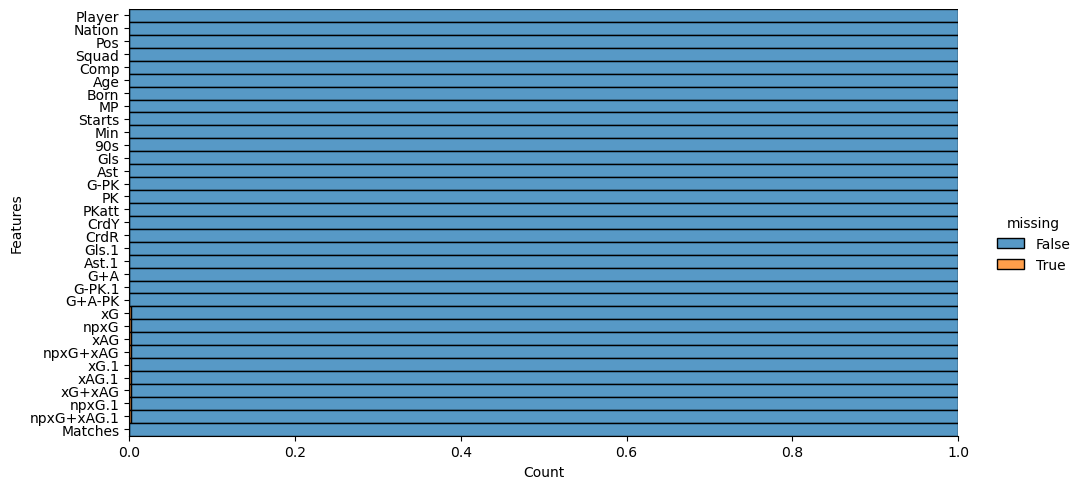

In [8]:
plt.figure(figsize=(14,16))
graph = sns.displot(data=df1.isna().melt(value_name='missing'), y='variable', hue='missing', aspect=2.0, multiple='fill')
graph.set(ylabel='Features');

In [9]:
#Nation should probably not be Imputed, let's take a closer look.
df1.loc[df1['Nation'].isna()]

,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,Min,...,xG,npxG,xAG,npxG+xAG,xG.1,xAG.1,xG+xAG,npxG.1,npxG+xAG.1,Matches
2690,Christian Rutjens,NaN,NaN,Benevento,it Serie A,NaN,NaN,1,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Matches


In [10]:
#Nation, Pos, Age and Born should probably not be Imputed. As there is only one
#row with missing data, let's look up from different source and complete.
df1.loc[df1.Player == 'Christian Rutjens', ['Nation', 'Pos', 'Age', 'Born']] = 'es ESP', 'DF', 19.0, '1998.0'
df1.loc[df1.Player == 'Christian Rutjens']

,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,Min,...,xG,npxG,xAG,npxG+xAG,xG.1,xAG.1,xG+xAG,npxG.1,npxG+xAG.1,Matches
2690,Christian Rutjens,es ESP,DF,Benevento,it Serie A,19.0,1998.0,1,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Matches


In [11]:
df1.describe(include=['object'])

,Player,Nation,Pos,Squad,Comp,Born,Matches
count,2429,2429,2429,2429,2429,2429.0,2429
unique,2429,107,10,98,5,26.0,1
top,Patrick van Aanholt,es ESP,DF,Benevento,es La Liga,1992.0,Matches
freq,1,347,745,36,511,209.0,2429


In [12]:
#Born is redundant with Age (numeric) and Matches seems irrevalant.
df1.drop(columns=['Born', 'Matches'], axis=1, inplace=True)
df = df1.reset_index(drop=True)

### Dataframe 2: Latest Salary <a id="subparagraph2"></a>
Omitted from Classification Model.

### Dataframe 3: Advanced GK stats <a id="subparagraph3"></a>
Midseason transfers will be treated same as in Dataframe 1.

https://fbref.com/en/comps/Big5/2017-2018/keepersadv/players/2017-2018-Big-5-European-Leagues-Stats

In [13]:
df3 = pd.read_csv("../data/raw/fut2017advgk.txt", header=1)
df3.head(5)

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,90s,GA,...,Launch%.1,AvgLen.1,Opp,Stp,Stp%,#OPA,#OPA/90,AvgDist,Matches,-9999
0,1,Antonio Adán,es ESP,GK,Betis,es La Liga,30,1987,30.0,53.0,...,59.7,44.4,468.0,17.0,3.6,22.0,0.73,14.6,Matches,65d62814
1,2,René Adler,de GER,GK,Mainz 05,de Bundesliga,32,1985,14.0,18.0,...,76.9,54.9,209.0,19.0,9.1,22.0,1.57,15.4,Matches,f71890f5
2,3,Adrián,es ESP,GK,West Ham,eng Premier League,30,1987,19.0,29.0,...,90.2,59.3,316.0,13.0,4.1,31.0,1.63,16.0,Matches,f76e6b4e
3,4,Alisson,br BRA,GK,Roma,it Serie A,24,1992,37.0,28.0,...,42.5,41.0,469.0,17.0,3.6,90.0,2.43,18.9,Matches,7a2e46a8
4,5,Sergio Álvarez,es ESP,GK,Celta Vigo,es La Liga,30,1986,16.4,29.0,...,65.9,50.6,214.0,8.0,3.7,18.0,1.10,14.1,Matches,8875b8c9


<Figure size 1400x1600 with 0 Axes>

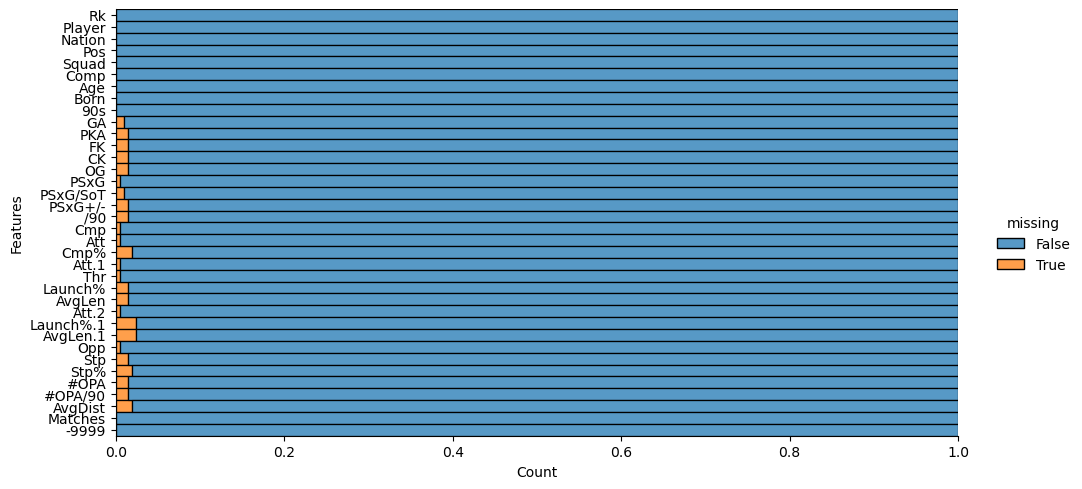

In [14]:
plt.figure(figsize=(14,16))
graph = sns.displot(data=df3.isna().melt(value_name='missing'), y='variable',hue='missing',aspect=2.0,multiple='fill')
graph.set(ylabel='Features');

In [15]:
advgkcols_to_use = df3.columns.difference(df.columns)
advgkcols_to_use = list(advgkcols_to_use.to_list())
advgkcols_to_use.append('Player')
df = pd.merge(df, df3[advgkcols_to_use], on='Player', how='left')
len(df)

2429

<Figure size 1600x1600 with 0 Axes>

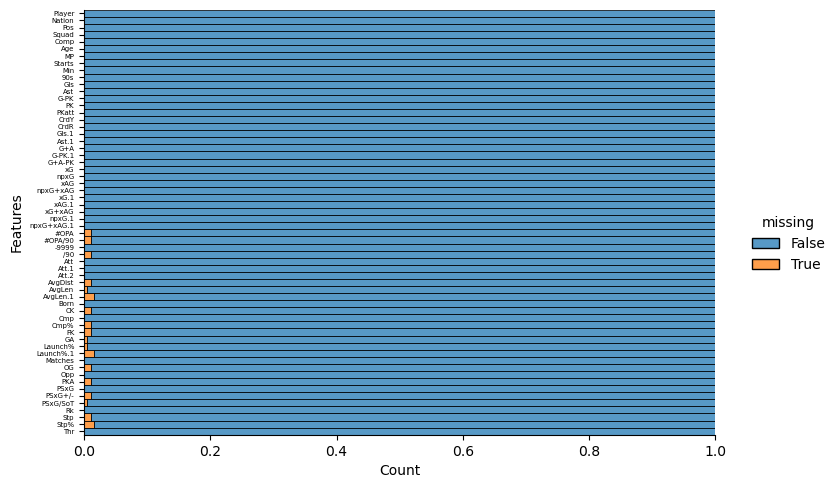

In [16]:
plt.figure(figsize=(16,16))
graph = sns.displot(data=df.loc[df['Pos']=='GK'].isna().melt(value_name='missing'), y='variable', hue='missing', aspect=1.6, multiple='fill')
graph.set_ylabels('Features', fontsize=10)
graph.set_yticklabels(fontsize=5);

In [17]:
del advgkcols_to_use[-1]
for col in advgkcols_to_use:
    df[col].fillna(value=0, inplace=True)
df.loc[df['Pos']!='GK'][['Player','Launch%']][:5]

,Player,Launch%
0,Patrick van Aanholt,0.0
1,Ignazio Abate,0.0
2,Aymen Abdennour,0.0
3,Aly Abeid,0.0
4,Mehdi Abeid,0.0


### Dataframe 4: Goal and Shot Creation Stats <a id="subparagraph4"></a>
Midseason transfers will be treated same as in Dataframe 1.

https://fbref.com/en/comps/Big5/2017-2018/gca/players/2017-2018-Big-5-European-Leagues-Stats

In [18]:
df4 = pd.read_csv("../data/raw/fut2017advgoalandshot.txt", header=1)
df4.head(3)

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,90s,Att,...,TI,CK,In,Out,Str,Cmp,Off,Blocks,Matches,-9999
0,1,Patrick van Aanholt,nl NED,DF,Crystal Palace,eng Premier League,26.0,1990.0,24.3,1176.0,...,235.0,11.0,3.0,5.0,2.0,884.0,3.0,31.0,Matches,5f09991f
1,2,Rolando Aarons,eng ENG,MFFW,Newcastle Utd,eng Premier League,21.0,1995.0,1.5,44.0,...,0.0,0.0,0.0,0.0,0.0,29.0,1.0,3.0,Matches,c5942695
2,3,Rolando Aarons,eng ENG,MFFW,Hellas Verona,it Serie A,21.0,1995.0,5.7,120.0,...,4.0,0.0,0.0,0.0,0.0,87.0,0.0,5.0,Matches,c5942695


<Figure size 1400x1600 with 0 Axes>

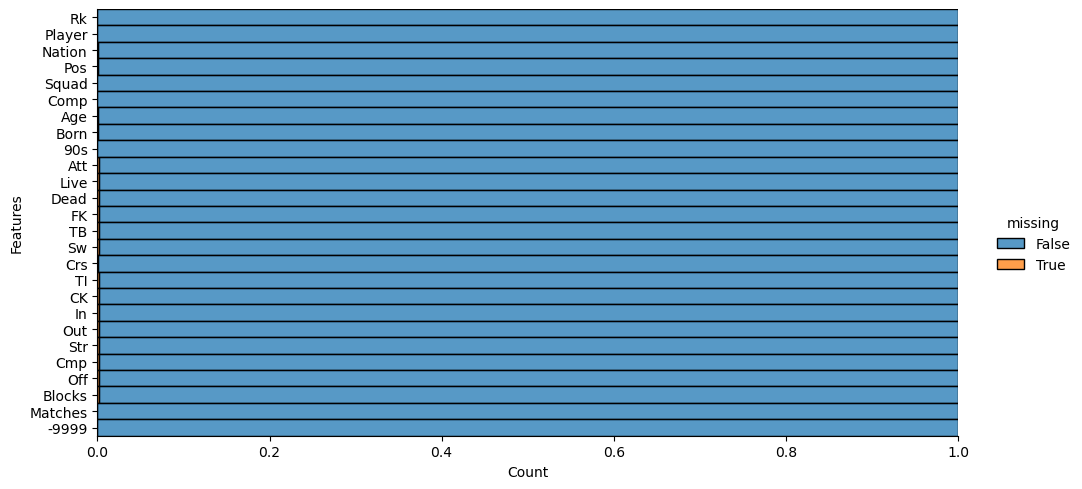

In [19]:
plt.figure(figsize=(14,16))
graph = sns.displot(data=df4.isna().melt(value_name='missing'), y='variable',hue='missing',aspect=2.0,multiple='fill')
graph.set(ylabel='Features');

In [20]:
df4.drop(columns=['Born', 'Age', 'Pos', 'Nation'], axis=1, inplace=True)

In [21]:
cols_to_use = df4.columns.difference(df.columns)
cols_to_use = list(cols_to_use.to_list())
cols_to_use.append('Player')
df = pd.merge(df, df4[cols_to_use], on='Player', how='left')
len(df)

2429

### Dataframe 5: Pass Type <a id="subparagraph5"></a>
Midseason transfers will be treated same as in Dataframe 1.

https://fbref.com/en/comps/Big5/2017-2018/passing_types/players/2017-2018-Big-5-European-Leagues-Stats

In [22]:
df5 = pd.read_csv("../data/raw/fut2017advpass.txt", header=1)
df5.head(5)

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,90s,Att,...,TI,CK,In,Out,Str,Cmp,Off,Blocks,Matches,-9999
0,1,Patrick van Aanholt,nl NED,DF,Crystal Palace,eng Premier League,26.0,1990.0,24.3,1176.0,...,235.0,11.0,3.0,5.0,2.0,884.0,3.0,31.0,Matches,5f09991f
1,2,Rolando Aarons,eng ENG,MFFW,Newcastle Utd,eng Premier League,21.0,1995.0,1.5,44.0,...,0.0,0.0,0.0,0.0,0.0,29.0,1.0,3.0,Matches,c5942695
2,3,Rolando Aarons,eng ENG,MFFW,Hellas Verona,it Serie A,21.0,1995.0,5.7,120.0,...,4.0,0.0,0.0,0.0,0.0,87.0,0.0,5.0,Matches,c5942695
3,4,Ignazio Abate,it ITA,DF,Milan,it Serie A,30.0,1986.0,11.7,776.0,...,112.0,0.0,0.0,0.0,0.0,625.0,4.0,21.0,Matches,1c529186
4,5,Aymen Abdennour,tn TUN,DF,Marseille,fr Ligue 1,27.0,1989.0,5.5,333.0,...,0.0,0.0,0.0,0.0,0.0,310.0,1.0,2.0,Matches,2f798b41


<Figure size 1400x1600 with 0 Axes>

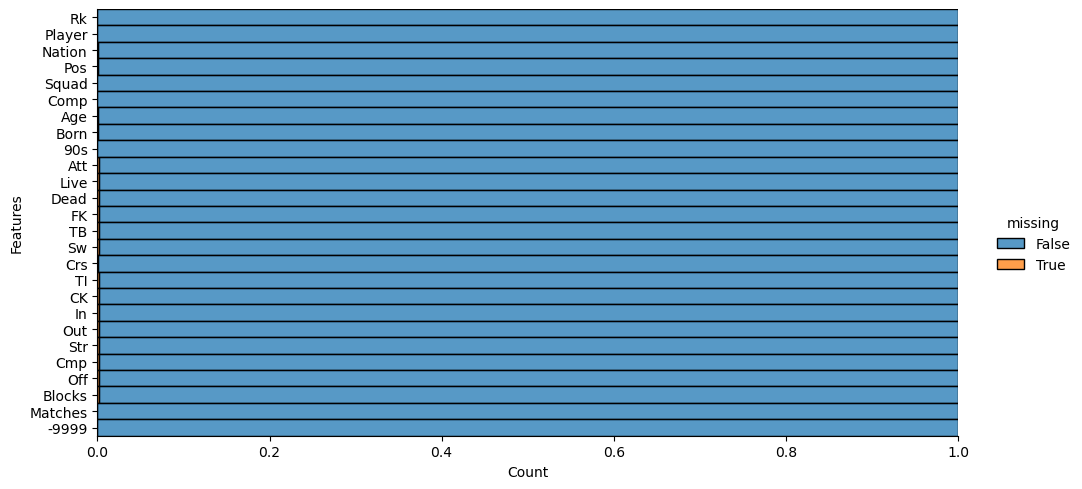

In [23]:
plt.figure(figsize=(14,16))
graph = sns.displot(data=df5.isna().melt(value_name='missing'), y='variable',hue='missing',aspect=2.0,multiple='fill')
graph.set(ylabel='Features');

In [24]:
cols_to_use = df5.columns.difference(df.columns)
cols_to_use = list(cols_to_use.to_list())
cols_to_use.append('Player')
df = pd.merge(df, df5[cols_to_use], on='Player', how='left')
len(df)

2429

### Dataframe 6: Shooting Stats <a id="subparagraph6"></a>
Midseason transfers will be treated same as in Dataframe 1.

https://fbref.com/en/comps/Big5/2017-2018/shooting/players/2017-2018-Big-5-European-Leagues-Stats

In [25]:
df6 = pd.read_csv("../data/raw/fut2017shooting.txt", header=1)
df6.head(3)

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,90s,Gls,...,FK,PK,PKatt,xG,npxG,npxG/Sh,G-xG,np:G-xG,Matches,-9999
0,1,Patrick van Aanholt,nl NED,DF,Crystal Palace,eng Premier League,26.0,1990.0,24.3,5,...,4.0,0,0,3.1,3.1,0.09,1.9,1.9,Matches,5f09991f
1,2,Rolando Aarons,eng ENG,MFFW,Newcastle Utd,eng Premier League,21.0,1995.0,1.5,0,...,0.0,0,0,0.1,0.1,0.03,-0.1,-0.1,Matches,c5942695
2,3,Rolando Aarons,eng ENG,MFFW,Hellas Verona,it Serie A,21.0,1995.0,5.7,0,...,0.0,0,0,0.2,0.2,0.05,-0.2,-0.2,Matches,c5942695


<Figure size 1400x1600 with 0 Axes>

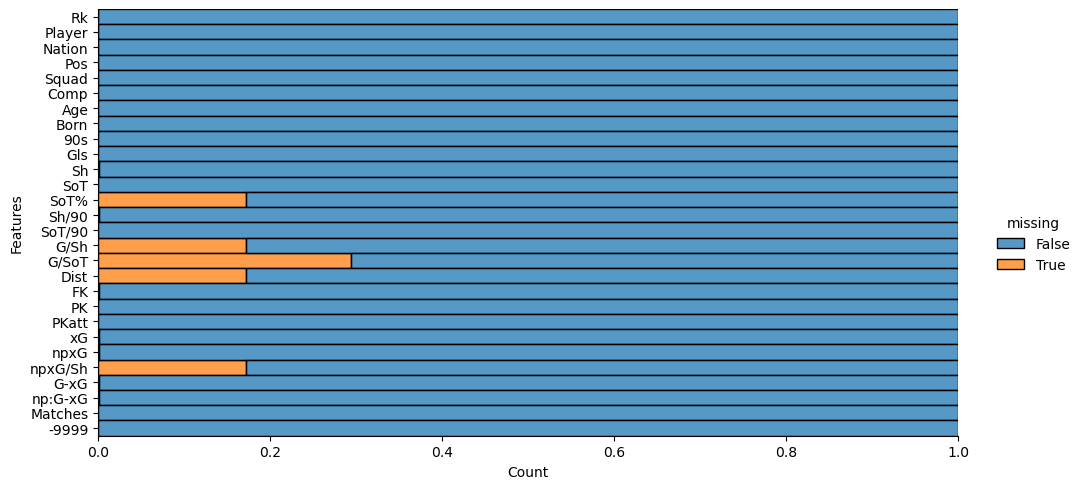

In [26]:
plt.figure(figsize=(14,16))
graph = sns.displot(data=df6.isna().melt(value_name='missing'), y='variable', hue='missing', aspect=2.0, multiple='fill')
graph.set(ylabel='Features');

In [27]:
df6.drop(axis=1, columns=['G/SoT', 'npxG/Sh', 'Dist', 'G/Sh', 'SoT%'], inplace=True)
df6.drop(axis=1, columns=['Nation', 'Born', 'Age', 'Pos'], inplace=True)

In [28]:
cols_to_use = df6.columns.difference(df.columns)
cols_to_use = list(cols_to_use.to_list())
cols_to_use.append('Player')
df = pd.merge(df, df6[cols_to_use], on='Player', how='left')
len(df)

2429

### Dataframe 7: Defensive Action Stats <a id="subparagraph7"></a>
Midseason transfers will be treated same as in Dataframe 1.

https://fbref.com/en/comps/Big5/2017-2018/defense/players/2017-2018-Big-5-European-Leagues-Stats

In [29]:
df7 = pd.read_csv("../data/raw/fut2017defact.txt", header=1)
df7.head(5)

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,90s,Att,...,TI,CK,In,Out,Str,Cmp,Off,Blocks,Matches,-9999
0,1,Patrick van Aanholt,nl NED,DF,Crystal Palace,eng Premier League,26.0,1990.0,24.3,1176.0,...,235.0,11.0,3.0,5.0,2.0,884.0,3.0,31.0,Matches,5f09991f
1,2,Rolando Aarons,eng ENG,MFFW,Newcastle Utd,eng Premier League,21.0,1995.0,1.5,44.0,...,0.0,0.0,0.0,0.0,0.0,29.0,1.0,3.0,Matches,c5942695
2,3,Rolando Aarons,eng ENG,MFFW,Hellas Verona,it Serie A,21.0,1995.0,5.7,120.0,...,4.0,0.0,0.0,0.0,0.0,87.0,0.0,5.0,Matches,c5942695
3,4,Ignazio Abate,it ITA,DF,Milan,it Serie A,30.0,1986.0,11.7,776.0,...,112.0,0.0,0.0,0.0,0.0,625.0,4.0,21.0,Matches,1c529186
4,5,Aymen Abdennour,tn TUN,DF,Marseille,fr Ligue 1,27.0,1989.0,5.5,333.0,...,0.0,0.0,0.0,0.0,0.0,310.0,1.0,2.0,Matches,2f798b41


<Figure size 1400x1600 with 0 Axes>

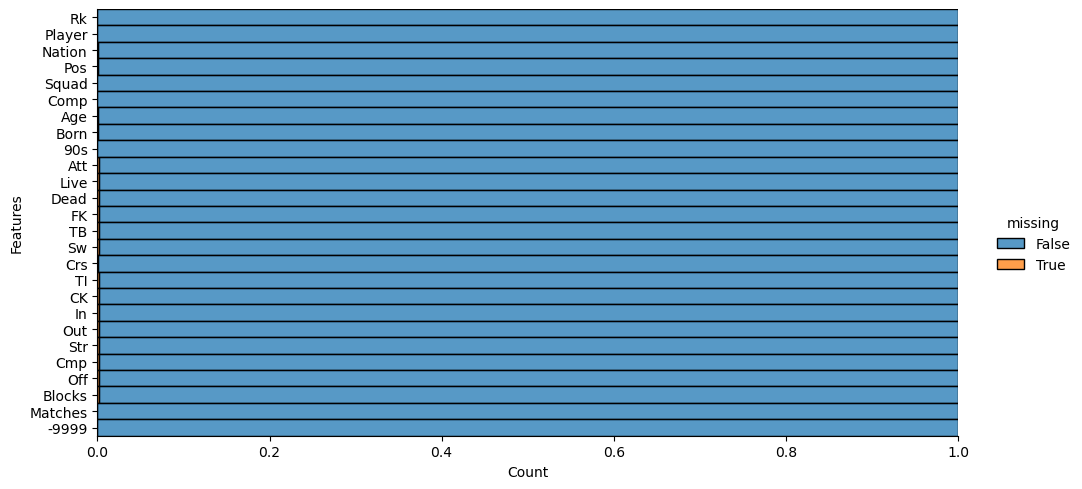

In [30]:
plt.figure(figsize=(14,16))
graph = sns.displot(data=df7.isna().melt(value_name='missing'), y='variable', hue='missing', aspect=2.0, multiple='fill')
graph.set(ylabel='Features');

In [31]:
cols_to_use = df7.columns.difference(df.columns)
cols_to_use = list(cols_to_use.to_list())
cols_to_use.append('Player')
df = pd.merge(df, df7[cols_to_use], on='Player', how='left')
len(df)

2429

### Dataframe 8: Goalkeeper Stats <a id="subparagraph8"></a>
Midseason transfers will be treated same as in Dataframe 1.

https://fbref.com/en/comps/Big5/2017-2018/keepers/players/2017-2018-Big-5-European-Leagues-Stats

In [32]:
df8 = pd.read_csv("../data/raw/fut2017gk.txt", header=1)
df8.head(3)

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,...,L,CS,CS%,PKatt,PKA,PKsv,PKm,Save%.1,Matches,-9999
0,1,Antonio Adán,es ESP,GK,Betis,es La Liga,30,1987,30,30,...,12.0,9.0,30.0,4.0,3.0,1.0,0.0,25.0,Matches,65d62814
1,2,René Adler,de GER,GK,Mainz 05,de Bundesliga,32,1985,14,14,...,6.0,4.0,28.6,2.0,1.0,0.0,1.0,0.0,Matches,f71890f5
2,3,Adrián,es ESP,GK,West Ham,eng Premier League,30,1987,19,19,...,6.0,6.0,31.6,1.0,1.0,0.0,0.0,0.0,Matches,f76e6b4e


<Figure size 1400x1600 with 0 Axes>

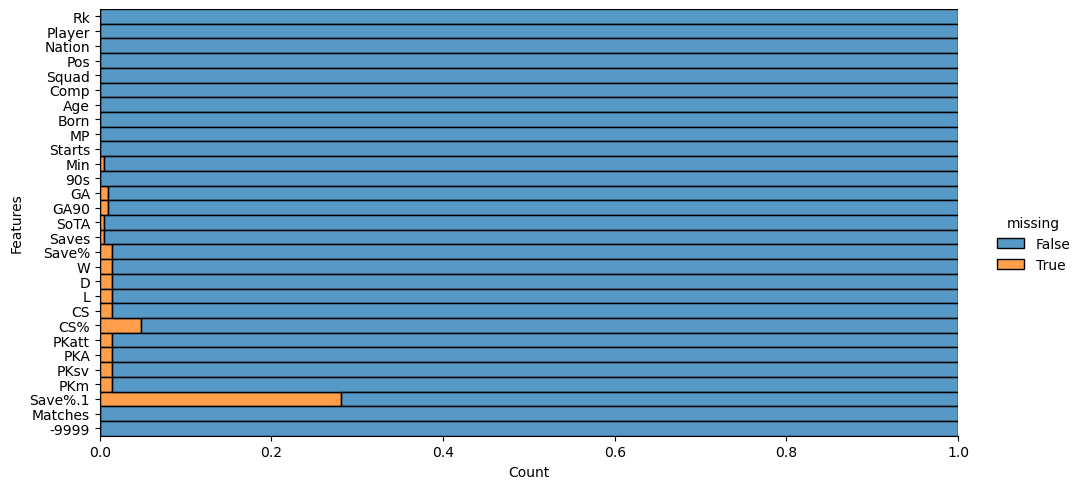

In [33]:
plt.figure(figsize=(14,16))
graph = sns.displot(data=df8.isna().melt(value_name='missing'), y='variable', hue='missing', aspect=2.0, multiple='fill')
graph.set(ylabel='Features');

In [34]:
df8.drop(axis=1, columns='Save%.1', inplace=True)

In [35]:
gkcols_to_use = df8.columns.difference(df.columns)
gkcols_to_use = list(gkcols_to_use.to_list())
gkcols_to_use.append('Player')
df = pd.merge(df, df8[gkcols_to_use], on='Player', how='left')
len(df)

2429

In [36]:
del gkcols_to_use[-1]
for col in gkcols_to_use:
    df[col].fillna(value=0, inplace=True)

### Dataframe 9: Miscelleanous Stats <a id="subparagraph9"></a>
Midseason transfers will be treated same as in Dataframe 1.

https://fbref.com/en/comps/Big5/2017-2018/misc/players/2017-2018-Big-5-European-Leagues-Stats

In [37]:
df9 = pd.read_csv("../data/raw/fut2017miscstats.txt", header=1)
df9.head(3)

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,90s,CrdY,...,TklW,PKwon,PKcon,OG,Recov,Won,Lost,Won%,Matches,-9999
0,1,Patrick van Aanholt,nl NED,DF,Crystal Palace,eng Premier League,26.0,1990.0,24.3,7,...,32.0,0.0,0.0,0.0,162.0,6.0,5.0,54.5,Matches,5f09991f
1,2,Rolando Aarons,eng ENG,MFFW,Newcastle Utd,eng Premier League,21.0,1995.0,1.5,0,...,4.0,0.0,0.0,0.0,9.0,1.0,3.0,25.0,Matches,c5942695
2,3,Rolando Aarons,eng ENG,MFFW,Hellas Verona,it Serie A,21.0,1995.0,5.7,0,...,8.0,0.0,0.0,0.0,19.0,9.0,15.0,37.5,Matches,c5942695


<Figure size 1400x1600 with 0 Axes>

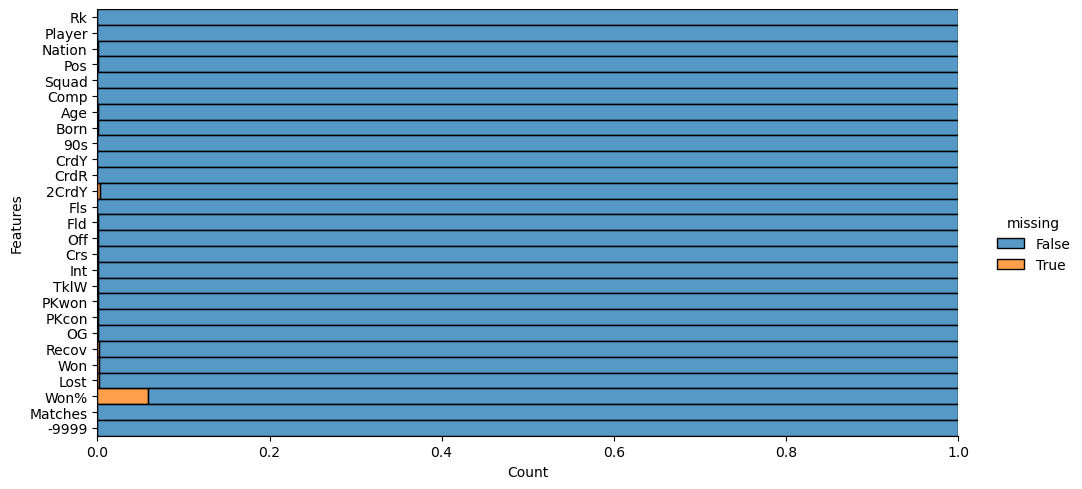

In [38]:
plt.figure(figsize=(14,16))
graph = sns.displot(data=df9.isna().melt(value_name='missing'), y='variable', hue='missing', aspect=2.0, multiple='fill')
graph.set(ylabel='Features');

In [39]:
df9.drop(axis=1, columns=['Born', 'Nation', 'Age', 'Pos'], inplace=True)

In [40]:
cols_to_use = df9.columns.difference(df.columns)
cols_to_use = list(cols_to_use.to_list())
cols_to_use.append('Player')
df = pd.merge(df, df9[cols_to_use], on='Player', how='left')
len(df)

2429

### Dataframe 10: Passing Stats <a id="subparagraph10"></a>
Midseason transfers will be treated same as in Dataframe 1.

https://fbref.com/en/comps/Big5/2017-2018/passing/players/2017-2018-Big-5-European-Leagues-Stats

In [41]:
df10 = pd.read_csv("../data/raw/fut2017passing.txt", header=1)
df10.head(3)

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,90s,Gls,...,FK,PK,PKatt,xG,npxG,npxG/Sh,G-xG,np:G-xG,Matches,-9999
0,1,Patrick van Aanholt,nl NED,DF,Crystal Palace,eng Premier League,26.0,1990.0,24.3,5,...,4.0,0,0,3.1,3.1,0.09,1.9,1.9,Matches,5f09991f
1,2,Rolando Aarons,eng ENG,MFFW,Newcastle Utd,eng Premier League,21.0,1995.0,1.5,0,...,0.0,0,0,0.1,0.1,0.03,-0.1,-0.1,Matches,c5942695
2,3,Rolando Aarons,eng ENG,MFFW,Hellas Verona,it Serie A,21.0,1995.0,5.7,0,...,0.0,0,0,0.2,0.2,0.05,-0.2,-0.2,Matches,c5942695


<Figure size 1400x1600 with 0 Axes>

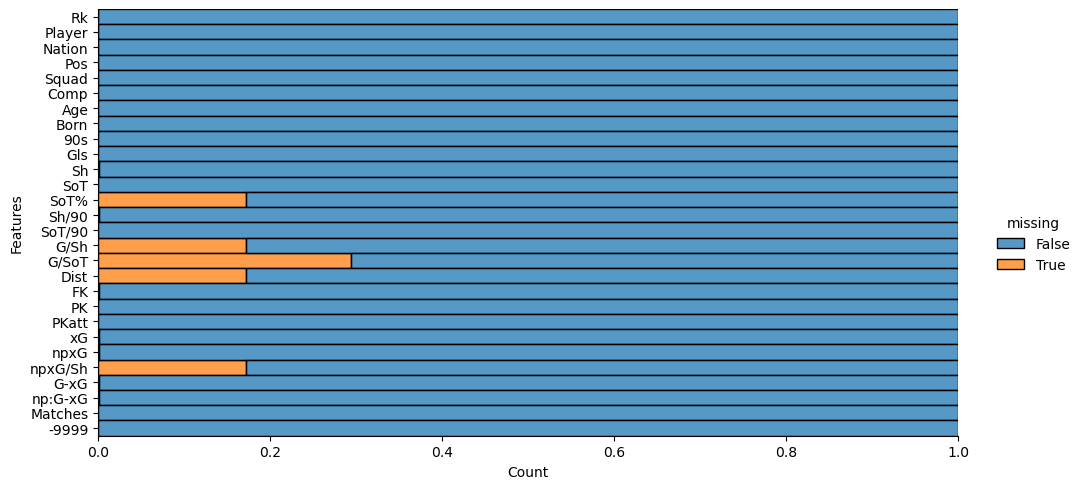

In [42]:
plt.figure(figsize=(14,16))
graph = sns.displot(data=df10.isna().melt(value_name='missing'), y='variable',hue='missing',aspect=2.0,multiple='fill')
graph.set(ylabel='Features');

In [43]:
df10.drop(axis=1, columns='G/SoT', inplace=True)
df10.drop(axis=1, columns=['Born', 'Nation', 'Age', 'Pos'], inplace=True)

In [44]:
cols_to_use = df10.columns.difference(df.columns)
cols_to_use = list(cols_to_use.to_list())
cols_to_use.append('Player')
df = pd.merge(df, df10[cols_to_use], on='Player', how='left')
len(df)

2429

### Dataframe 11: Playtime Stats <a id="subparagraph11"></a>
Midseason transfers will be treated same as in Dataframe 1.

https://fbref.com/en/comps/Big5/2017-2018/playingtime/players/2017-2018-Big-5-European-Leagues-Stats

In [45]:
df11 = pd.read_csv("../data/raw/fut2017playtime.txt", header=1)
df11.head(3)

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Min,...,+/-,+/-90,On-Off,onxG,onxGA,xG+/-,xG+/-90,On-Off.1,Matches,-9999
0,1,Ismael Aaneba,fr FRA,DF,Strasbourg,fr Ligue 1,18.0,1999.0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Matches,a7e4760c
1,2,Patrick van Aanholt,nl NED,DF,Crystal Palace,eng Premier League,26.0,1990.0,28,2184.0,...,-7.0,-0.29,-0.07,32.2,34.7,-2.5,-0.10,-0.66,Matches,5f09991f
2,3,Rolando Aarons,eng ENG,MFFW,Newcastle Utd,eng Premier League,21.0,1995.0,4,139.0,...,-1.0,-0.65,-0.46,0.4,2.9,-2.6,-1.66,-1.43,Matches,c5942695


<Figure size 1400x1600 with 0 Axes>

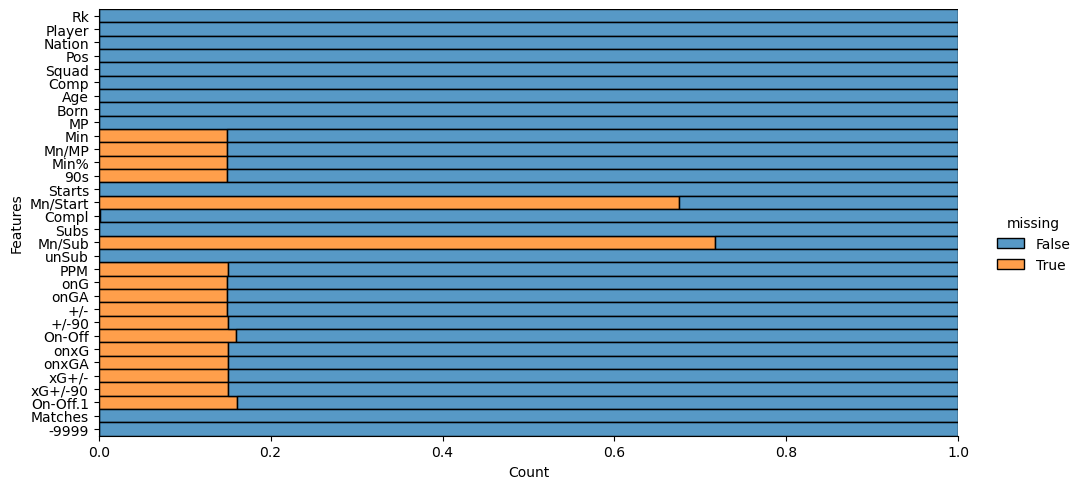

In [46]:
plt.figure(figsize=(14,16))
graph = sns.displot(data=df11.isna().melt(value_name='missing'), y='variable', hue='missing', aspect=2.0, multiple='fill')
graph.set(ylabel='Features');

In [47]:
df11.drop(axis=1, columns=['Mn/Start', 'Mn/Sub'], inplace=True)
df11.drop(axis=1, columns=['Born', 'Nation', 'Age', 'Pos'], inplace=True)

In [48]:
df11.drop_duplicates(subset='Player', inplace=True)

In [49]:
cols_to_use = df11.columns.difference(df.columns)
cols_to_use = list(cols_to_use.to_list())
cols_to_use.append('Player')
df = pd.merge(df, df11[cols_to_use], on='Player', how='left')
len(df)

2429

### Dataframe 12: Possession Stats <a id="subparagraph12"></a>
Midseason transfers will be treated same as in Dataframe 1.

https://fbref.com/en/comps/Big5/2017-2018/possession/players/2017-2018-Big-5-European-Leagues-Stats

In [50]:
df12 = pd.read_csv("../data/raw/fut2017poss.txt", header=1)
df12.head(3)

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,90s,Att,...,TI,CK,In,Out,Str,Cmp,Off,Blocks,Matches,-9999
0,1,Patrick van Aanholt,nl NED,DF,Crystal Palace,eng Premier League,26.0,1990.0,24.3,1176.0,...,235.0,11.0,3.0,5.0,2.0,884.0,3.0,31.0,Matches,5f09991f
1,2,Rolando Aarons,eng ENG,MFFW,Newcastle Utd,eng Premier League,21.0,1995.0,1.5,44.0,...,0.0,0.0,0.0,0.0,0.0,29.0,1.0,3.0,Matches,c5942695
2,3,Rolando Aarons,eng ENG,MFFW,Hellas Verona,it Serie A,21.0,1995.0,5.7,120.0,...,4.0,0.0,0.0,0.0,0.0,87.0,0.0,5.0,Matches,c5942695


<Figure size 1400x1600 with 0 Axes>

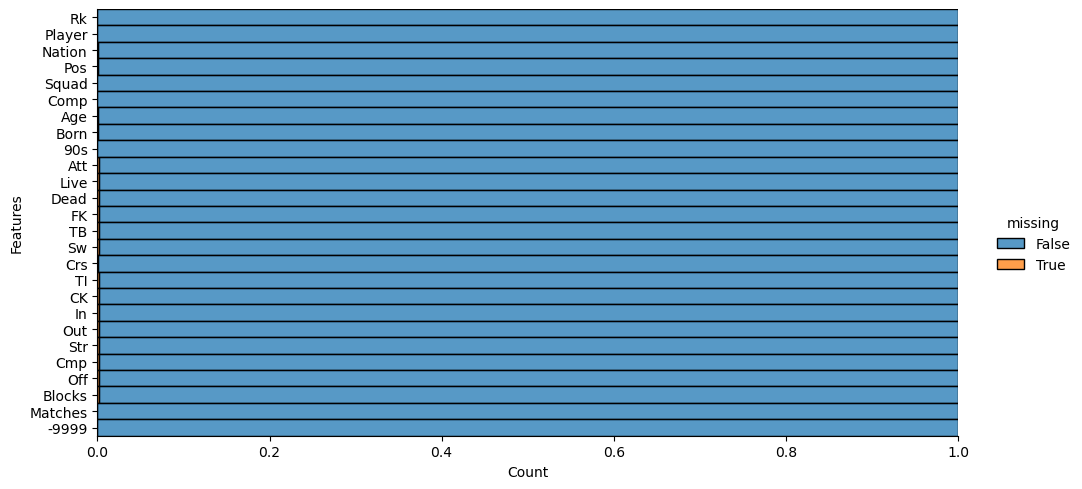

In [51]:
plt.figure(figsize=(14,16))
graph = sns.displot(data=df12.isna().melt(value_name='missing'), y='variable', hue='missing', aspect=2.0, multiple='fill')
graph.set(ylabel='Features');

In [52]:
cols_to_use = df12.columns.difference(df.columns)
cols_to_use = list(cols_to_use.to_list())
cols_to_use.append('Player')
df = pd.merge(df, df12[cols_to_use], on='Player', how='left')
len(df)

2429

### Dataframe 13: Team Wages <a id="subparagraph13"></a>
Midseason transfers will be treated same as in Dataframe 1.

Team Wage as feature is too directly linked to target. Will bin this feature.

https://fbref.com/en/comps/Big5/2017-2018/wages/2017-2018-Big-5-European-Leagues-Wages

In [53]:
df13 = pd.read_csv("../data/raw/fut2017teamwages.txt")
df13.head(3)

,Rk,Squad,Comp,# Pl,Weekly Wages,Annual Wages,% Estimated
0,1,Barcelona,es La Liga,33,€ 4682115 (£ 3925993 $4771599),€ 243470000 (£ 204151634 $248123125),100%
1,2,Real Madrid,es La Liga,32,€ 3949904 (£ 3312027 $4025393),€ 205395000 (£ 172225426 $209320446),100%
2,3,Paris S-G,fr Ligue 1,35,€ 3895462 (£ 3266377 $3969910),€ 202564000 (£ 169851608 $206435344),100%


In [54]:
#GDP as Annual Player Salaries are expressed in that currency
df13['Annual Wages'] = [i.split(" ")[3] for i in df13['Annual Wages']]

In [55]:
teamwages = {
    df13['Squad'][i]: df13['Annual Wages'][i] for i in range(len(df13))
}

In [56]:
teamwage = [teamwages.get(squad) for squad in df['Squad']]
df['TeamWage'] = teamwage

In [57]:
df[df['TeamWage'].isnull()][:4]

,Player,Nation,Pos,Squad,Comp,Age,MP,Starts,Min,90s,...,PPM,Subs,onG,onGA,onxG,onxGA,unSub,xG+/-,xG+/-90,TeamWage
43,Miiko Albornoz,cl CHI,DFMF,Hannover 96,de Bundesliga,26.0,10,7,703,7.8,...,0.70,3,10.0,17.0,10.1,14.5,10,-4.4,-0.57,None
53,Alexander,ar ARG,MFFW,Leganés,es La Liga,28.0,13,13,1060,11.8,...,1.31,0,8.0,12.0,13.8,14.7,0,-0.9,-0.08,None
79,Jon Ander Serantes,es ESP,GK,Leganés,es La Liga,27.0,1,1,90,1.0,...,3.00,0,3.0,2.0,1.4,2.2,2,-0.8,-0.77,None
87,Miguel Ángel Guerrero,es ESP,FW,Leganés,es La Liga,27.0,22,15,1442,16.0,...,1.05,7,17.0,24.0,16.4,23.1,2,-6.7,-0.42,None


In [58]:
#calculated from sal17 Wages in df2 in other notebook
df.loc[df['Squad'] == 'Hannover 96', 'TeamWage'] = str(32388451.0)

In [59]:
#calculated from sal17 Wages in df2 in other notebook
df.loc[df['Squad'] == 'Leganés', 'TeamWage'] = str(10847290.0)

In [60]:
df[df['TeamWage'].isnull()]

,Player,Nation,Pos,Squad,Comp,Age,MP,Starts,Min,90s,...,PPM,Subs,onG,onGA,onxG,onxGA,unSub,xG+/-,xG+/-90,TeamWage


### Dataframe 14: 2022 Active Players <a id="subparagraph14"></a>
Midseason transfers will be treated same as in Dataframe 1.

https://fbref.com/en/comps/Big5/Big-5-European-Leagues-Stats

In [61]:
df14 = pd.read_csv("../data/raw/fut2022standard.txt", header=1)
df14.head(3)

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,...,npxG,xAG,npxG+xAG,xG.1,xAG.1,xG+xAG,npxG.1,npxG+xAG.1,Matches,-9999
0,1,Brenden Aaronson,us USA,MFFW,Leeds United,eng Premier League,22-038,2000.0,14,14,...,1.9,2.9,4.8,0.14,0.22,0.36,0.14,0.36,Matches,5bc43860
1,2,Yunis Abdelhamid,ma MAR,DF,Reims,fr Ligue 1,35-062,1987.0,15,15,...,1.3,0.2,1.6,0.09,0.02,0.10,0.09,0.10,Matches,32c2d95f
2,3,Himad Abdelli,fr FRA,MFFW,Angers,fr Ligue 1,23-012,1999.0,7,2,...,0.4,0.5,0.9,0.15,0.21,0.36,0.15,0.36,Matches,7978cbf0


In [62]:
players_22 = set(df14['Player'])
len(players_22)

2330

In [63]:
active22 = pd.DataFrame()
active22['Player'] = list(players_22)
active22['Active22'] = True
df = pd.merge(df, active22, how='left', on='Player')
len(df)

2429

In [64]:
df['Active22'].fillna(False, inplace=True)

<Figure size 1600x1600 with 0 Axes>

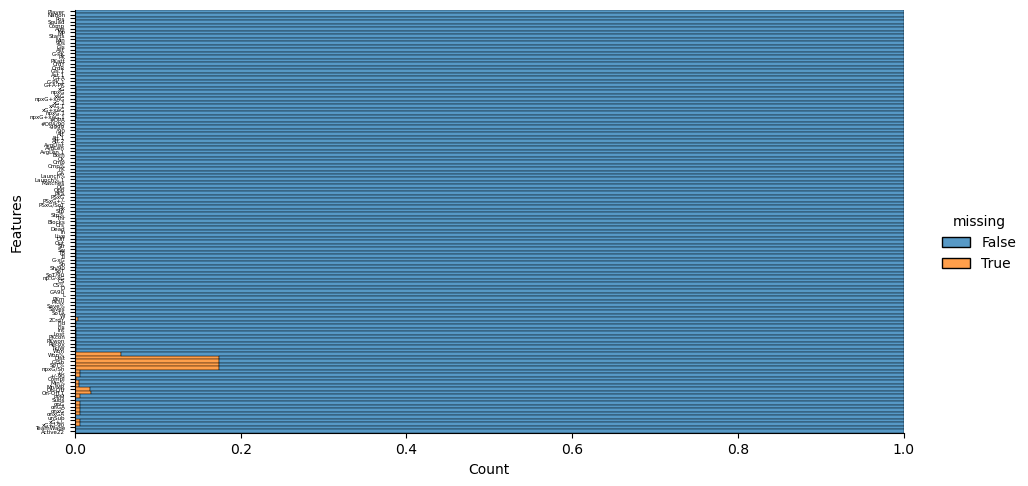

In [65]:
plt.figure(figsize=(16,16))
graph = sns.displot(data=df.isna().melt(value_name='missing'), y='variable', aspect=2.0, hue='missing', multiple='fill')
graph.set_ylabels('Features', fontsize=10)
graph.set_yticklabels(fontsize=4);

## EDA of Combined Dataframe <a id="paragraph3"></a>
Time to deal with NaNs, nulls, objects, cardinality, etc.

In [66]:
df.describe(include=['object'])

,Player,Nation,Pos,Squad,Comp,-9999,Matches,TeamWage
count,2429,2429,2429,2429,2429,2429,2429,2429
unique,2429,107,10,98,5,201,2,98
top,Patrick van Aanholt,es ESP,DF,Benevento,es La Liga,0,0,14861727
freq,1,347,745,36,511,2229,2229,36


In [67]:
df.drop('Squad', axis=1, inplace=True)
df.drop('-9999', axis=1, inplace=True)
df.drop('Matches', axis=1, inplace=True)

### Nations: Fix NaN and Reduce Cardinality <a name="subparagraph2"></a>
One player was missing stats, oopulated with real data above. Top ten nations represented in big 5 kept. All others coded as OTHERS before One Hot Encoding. All instances of OHE will drop a column to mitigate risk of colinearity when modeling.

In [68]:
print(df['Nation'].values)
df.groupby('Nation')['Nation'].count().sort_values(ascending=False).head(10)

['nl NED' 'it ITA' 'tn TUN' ... 'za RSA' 'es ESP' 'es ESP']


Nation
es ESP     347
fr FRA     272
it ITA     245
de GER     217
eng ENG    166
ar ARG      93
br BRA      92
sn SEN      50
nl NED      44
be BEL      44
Name: Nation, dtype: int64

In [69]:
#Local players (ie from Big 5 home countries). Bool
localcountries = ['es ESP', 'fr FRA', 'it ITA', 'de GER', 'eng ENG']
df['local'] = df['Nation'].apply(lambda x: x in localcountries)
df['local'].value_counts()

True     1247
False    1182
Name: local, dtype: int64

In [70]:
df.drop('Nation', inplace=True, axis=1)

### Postions: Nulls, NaNs and OHE <a name="subparagraph3"></a> 
A closer look.

In [71]:
df['Pos'].unique()

array(['DF', 'MF', 'FW', 'GK', 'DFFW', 'DFMF', 'MFFW', 'FWMF', 'MFDF',
       'FWDF'], dtype=object)

In [72]:
df['Pos'].isnull().value_counts()

False    2429
Name: Pos, dtype: int64

In [73]:
df['Pos'].value_counts()

DF      745
MF      517
FW      299
FWMF    242
MFFW    239
GK      198
DFMF     82
MFDF     54
DFFW     36
FWDF     17
Name: Pos, dtype: int64

In [74]:
utilitydefender = ['DFMF', 'MFDF', 'DFFW', 'FWDF']
df['Pos'] = df['Pos'].apply(lambda x: 'UTIDEF' if x in utilitydefender else x)
df['Pos'].value_counts()

DF        745
MF        517
FW        299
FWMF      242
MFFW      239
GK        198
UTIDEF    189
Name: Pos, dtype: int64

In [75]:
utilityattacker = ['FWMF', 'MFFW']
df['Pos'] = df['Pos'].apply(lambda x: 'UTIATT' if x in utilityattacker else x)
df['Pos'].value_counts()

DF        745
MF        517
UTIATT    481
FW        299
GK        198
UTIDEF    189
Name: Pos, dtype: int64

In [76]:
onehotencoder = OneHotEncoder()
X = onehotencoder.fit_transform(df['Pos'].values.reshape(-1,1)).toarray()
dfOneHot = pd.DataFrame(X, columns=[f"Pos_{int(i)}" for i in range(6)])
df = pd.concat([df, dfOneHot], axis=1)
df = df.drop(['Pos'], axis=1)
print(df['Pos_0'].sum())
df.drop('Pos_0', axis=1, inplace=True)

745.0


### Comps: NaNs and OHE <a name="subparagraph5"></a> 

In [77]:
df['Comp'].isna().value_counts()

False    2429
Name: Comp, dtype: int64

In [78]:
df['Comp'].value_counts()

es La Liga            511
fr Ligue 1            506
it Serie A            492
eng Premier League    476
de Bundesliga         444
Name: Comp, dtype: int64

In [79]:
onehotencoder = OneHotEncoder()
X = onehotencoder.fit_transform(df['Comp'].values.reshape(-1,1)).toarray()
dfOneHot = pd.DataFrame(X, columns=[f"Comp_{int(i)}" for i in range(5)])
df = pd.concat([df, dfOneHot], axis=1)
df = df.drop(['Comp'], axis=1)
print(df['Comp_0'].sum())
df.drop('Comp_0', axis=1, inplace=True)

444.0


### TeamWage: Convert to Int and Encode <a name="subparagraph6"></a> 

In [80]:
df['TeamWage'] = df['TeamWage'].astype(float).astype(int)

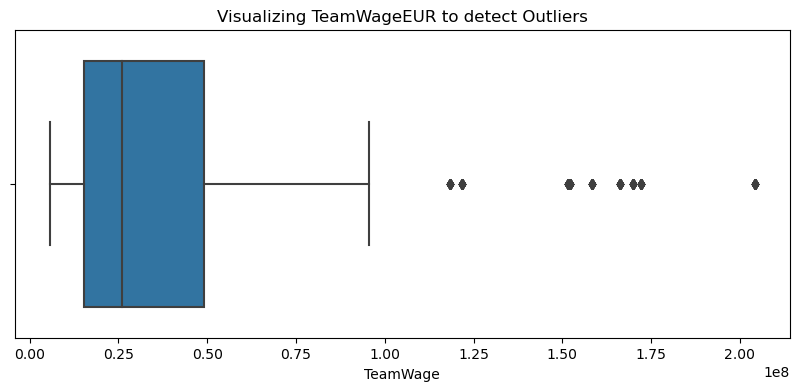

In [81]:
plt.figure(figsize=(10,4))
ax = sns.boxplot(df['TeamWage'])
ax.set_title('Visualizing TeamWageEUR to detect Outliers')
plt.show();

In [82]:
df['TeamWagebins'] = pd.qcut(df['TeamWage'], 6)

In [83]:
df["TeamWagebins"].value_counts()

(5760547.999, 12393992.0]    413
(18287868.0, 25945961.0]     408
(25945961.0, 42219000.0]     407
(12393992.0, 18287868.0]     403
(42219000.0, 68041000.0]     402
(68041000.0, 204151634.0]    396
Name: TeamWagebins, dtype: int64

In [84]:
df['TeamWagebins'] = le.fit_transform(df['TeamWagebins'])
df['TeamWagebins'].value_counts()

0    413
2    408
3    407
1    403
4    402
5    396
Name: TeamWagebins, dtype: int64

In [85]:
df.drop(columns="TeamWage", axis=1, inplace=True)

In [86]:
df.describe(include=['object'])

,Player
count,2429
unique,2429
top,Patrick van Aanholt
freq,1


In [87]:
df.to_csv('../data/processed/clfclean.csv')

## Baselines and Feature Intercorrelation <a id="paragraph4"></a>
Final review of database before creating models for the various hypothesis.

### Feature Intercorrelation <a id="subparagraph1"></a> 
With full df, as well as df removing intercorrelated features at >95% and >90%.

In [88]:
df = pd.read_csv('../data/processed/clfclean.csv', index_col=0)

X = df.drop(['Active22','Player'], axis=1)
y = df["Active22"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [89]:
X.shape

(2429, 123)

In [90]:
corr = X.corr()
c1 = corr.abs().unstack()
c1.sort_values(ascending=True, inplace=True)
columns_above_95 = [(col1, col2) for col1, col2 in c1.index if c1[col1,col2] > 0.95 and col1 != col2]
print(len(columns_above_95)/2)
columns_above_95[:8:2]

82.0


[('AvgLen.1', 'AvgDist'),
 ('Save%', 'Cmp%'),
 ('SoTA', 'L'),
 ('AvgLen.1', 'Save%')]

In [91]:
cor_matrix = X.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))

### Classifier Baseline <a id="subparagraph2"></a> 
With full df, as well as df removing intercorrelated features at >95% and >90%.

In [92]:
#2:1 so will use F1 as scoring goal
df['Active22'].value_counts()

False    1540
True      889
Name: Active22, dtype: int64

In [93]:
baseline_model = xgboost.XGBClassifier(random_state=42)

baseline_model.fit(X_train, y_train, eval_metric='logloss')
baseline_model.score(X_test, y_test)

0.7530864197530864

In [94]:
y_pred = baseline_model.predict(X_test)
f1_score(y_test, y_pred)

0.6103896103896104

In [95]:
models_summary = pd.DataFrame(columns=["Model", "F1", "Notes"])

In [96]:
#modificado para CLF F1
def save_results(model, param_notes):
    models_summary.loc[len(models_summary)] = [
                        model,
                        f1_score(y_test, model.predict(X_test)), 
                        param_notes
                        ]

In [97]:
save_results(baseline_model, "Baseline")
models_summary

,Model,F1,Notes
0,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.61039,Baseline


Active 22: Key Feature - onxG

Expected goals by team while on pitch
xG totals include penalty kicks, but do not include penalty shootouts (unless otherwise noted).

In [98]:
eli5.show_weights(baseline_model)

Weight,Feature
0.0573,onG
0.0341,onxG
0.0299,Age
0.0274,Launch%
0.0271,/90
0.0245,GA
0.0192,PSxG+/-
0.0187,AvgDist
0.0135,Compl
0.0135,PK


Drop NANs

In [99]:
df = pd.read_csv('../data/processed/clfclean.csv', index_col=0)

In [100]:
print(len(df))
df.dropna(inplace=True)
len(df)

2429


1960

In [101]:
X = df.drop(['Active22','Player'], axis=1)
y = df["Active22"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

xgb_clf = xgboost.XGBClassifier(random_state=42, scoring=f1_score)

xgb_clf.fit(X_train, y_train, eval_metric='logloss')
xgb_clf.score(X_test, y_test)

y_pred = xgb_clf.predict(X_test)
save_results(xgb_clf, "Baseline. nN")

In [102]:
models_summary.sort_values(by='F1', ascending=False)

,Model,F1,Notes
1,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.646865,Baseline. nN
0,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.610390,Baseline


KNN Impute NaNs

In [103]:
df = pd.read_csv('../data/processed/clfclean.csv', index_col=0)

In [104]:
cleanupDF(df)

In [105]:
X = df.drop(['Active22','Player'], axis=1)
y = df["Active22"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

xgb_clf = xgboost.XGBClassifier(random_state=42, scoring=f1_score)

xgb_clf.fit(X_train, y_train, eval_metric='logloss')
xgb_clf.score(X_test, y_test)

y_pred = xgb_clf.predict(X_test)
models_summary.sort_values(by='F1', ascending=False)

,Model,F1,Notes
1,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.646865,Baseline. nN
0,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.610390,Baseline


In [106]:
#dropNA better F1 than KNNImputer

Baseline DropNA. Check Feature Correlation

In [107]:
df = pd.read_csv('../data/processed/clfclean.csv', index_col=0)

print(len(df))
df.dropna(inplace=True)
print(len(df))

df.to_csv('../data/processed/clfnN.csv')

2429
1960


In [108]:
to_drop90 = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]
to_drop91 = [column for column in upper_tri.columns if any(upper_tri[column] > 0.91)]
to_drop92 = [column for column in upper_tri.columns if any(upper_tri[column] > 0.92)]
to_drop93 = [column for column in upper_tri.columns if any(upper_tri[column] > 0.93)]
to_drop94 = [column for column in upper_tri.columns if any(upper_tri[column] > 0.94)]
to_drop95 = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
to_drop96 = [column for column in upper_tri.columns if any(upper_tri[column] > 0.96)]
to_drop97 = [column for column in upper_tri.columns if any(upper_tri[column] > 0.97)]
to_drop98 = [column for column in upper_tri.columns if any(upper_tri[column] > 0.98)]
to_drop99 = [column for column in upper_tri.columns if any(upper_tri[column] > 0.99)]

X90 = X.drop(columns=to_drop90, axis=1)
X91 = X.drop(columns=to_drop91, axis=1)
X92 = X.drop(columns=to_drop92, axis=1)
X93 = X.drop(columns=to_drop93, axis=1)
X94 = X.drop(columns=to_drop94, axis=1)
X95 = X.drop(columns=to_drop95, axis=1)
X96 = X.drop(columns=to_drop96, axis=1)
X97 = X.drop(columns=to_drop97, axis=1)
X98 = X.drop(columns=to_drop98, axis=1)
X99 = X.drop(columns=to_drop99, axis=1)

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X90, y, test_size = 0.20, random_state = 42)
xgb_clf = xgboost.XGBClassifier(random_state=42, scoring=f1_score)
xgb_clf.fit(X_train, y_train, eval_metric='logloss')
print("FC check", f1_score(y_test, xgb_clf.predict(X_test)))

X_train, X_test, y_train, y_test = train_test_split(X91, y, test_size = 0.20, random_state = 42)
xgb_clf = xgboost.XGBClassifier(random_state=42, scoring=f1_score)
xgb_clf.fit(X_train, y_train, eval_metric='logloss')
print("FC check", f1_score(y_test, xgb_clf.predict(X_test)))

X_train, X_test, y_train, y_test = train_test_split(X92, y, test_size = 0.20, random_state = 42)
xgb_clf = xgboost.XGBClassifier(random_state=42, scoring=f1_score)
xgb_clf.fit(X_train, y_train, eval_metric='logloss')
print("FC check", f1_score(y_test, xgb_clf.predict(X_test)))

X_train, X_test, y_train, y_test = train_test_split(X93, y, test_size = 0.20, random_state = 42)
xgb_clf = xgboost.XGBClassifier(random_state=42, scoring=f1_score)
xgb_clf.fit(X_train, y_train, eval_metric='logloss')
print("FC check", f1_score(y_test, xgb_clf.predict(X_test)))

X_train, X_test, y_train, y_test = train_test_split(X94, y, test_size = 0.20, random_state = 42)
xgb_clf = xgboost.XGBClassifier(random_state=42, scoring=f1_score)
xgb_clf.fit(X_train, y_train, eval_metric='logloss')
print("FC check", f1_score(y_test, xgb_clf.predict(X_test)))

X_train, X_test, y_train, y_test = train_test_split(X95, y, test_size = 0.20, random_state = 42)
xgb_clf = xgboost.XGBClassifier(random_state=42, scoring=f1_score)
xgb_clf.fit(X_train, y_train, eval_metric='logloss')
print("FC check", f1_score(y_test, xgb_clf.predict(X_test)))

X_train, X_test, y_train, y_test = train_test_split(X96, y, test_size = 0.20, random_state = 42)
xgb_clf = xgboost.XGBClassifier(random_state=42, scoring=f1_score)
xgb_clf.fit(X_train, y_train, eval_metric='logloss')
print("FC check", f1_score(y_test, xgb_clf.predict(X_test)))

X_train, X_test, y_train, y_test = train_test_split(X97, y, test_size = 0.20, random_state = 42)
xgb_clf = xgboost.XGBClassifier(random_state=42, scoring=f1_score)
xgb_clf.fit(X_train, y_train, eval_metric='logloss')
print("FC check", f1_score(y_test, xgb_clf.predict(X_test)))

X_train, X_test, y_train, y_test = train_test_split(X98, y, test_size = 0.20, random_state = 42)
xgb_clf = xgboost.XGBClassifier(random_state=42, scoring=f1_score)
xgb_clf.fit(X_train, y_train, eval_metric='logloss')
print("FC check", f1_score(y_test, xgb_clf.predict(X_test)))

X_train, X_test, y_train, y_test = train_test_split(X99, y, test_size = 0.20, random_state = 42)
xgb_clf = xgboost.XGBClassifier(random_state=42, scoring=f1_score)
xgb_clf.fit(X_train, y_train, eval_metric='logloss')
print("FC check", f1_score(y_test, xgb_clf.predict(X_test)))

FC check 0.5974025974025975
FC check 0.6298701298701298
FC check 0.6109324758842444
FC check 0.6206896551724138
FC check 0.620253164556962
FC check 0.6153846153846154
FC check 0.5870967741935484
FC check 0.6366559485530546
FC check 0.6246056782334385
FC check 0.6387096774193548


Dropping intercorrelated columns do not improve scores for this model.

In [110]:
models_summary.sort_values(by='F1', ascending=False)

,Model,F1,Notes
1,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.646865,Baseline. nN
0,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.610390,Baseline


PCA

In [111]:
df = pd.read_csv('../data/processed/clfnN.csv', index_col=0)

In [112]:
X = df.drop(['Active22','Player'], axis=1)
y = df["Active22"]

scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(data_rescaled, y, test_size = 0.20, random_state = 42)

In [113]:
X.shape

(1960, 123)

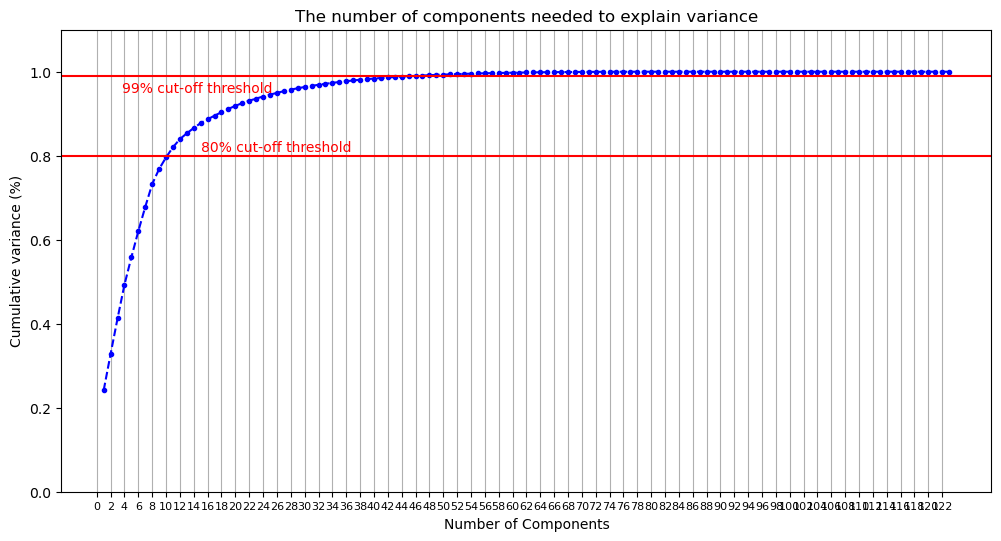

In [114]:
pca = PCA().fit(data_rescaled)

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 124, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='.', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 123, step=2), fontsize=8) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.8, color='r', linestyle='-')
plt.axhline(y=0.99, color='r', linestyle='-')
plt.text(15.1, 0.81, '80% cut-off threshold', color = 'red', fontsize=10)
plt.text(3.6, 0.95, '99% cut-off threshold', color = 'red', fontsize=10)

ax.grid(axis='x')
plt.show();

In [115]:
pca.explained_variance_ratio_.cumsum()

array([0.24140926, 0.32794559, 0.4124654 , 0.49300407, 0.5583465 ,
       0.62048934, 0.67816488, 0.73237721, 0.76842781, 0.79601487,
       0.82027496, 0.83963055, 0.85338393, 0.86600806, 0.87771105,
       0.88680328, 0.89537992, 0.90359128, 0.91157374, 0.91865181,
       0.92532118, 0.93085926, 0.93608351, 0.94092942, 0.94543708,
       0.94963844, 0.95365601, 0.95740475, 0.96061716, 0.96367588,
       0.96630086, 0.96887188, 0.97130251, 0.97346351, 0.97554127,
       0.97742239, 0.97922391, 0.98091433, 0.98237727, 0.98375749,
       0.98503791, 0.98625478, 0.98742838, 0.98840344, 0.98931463,
       0.99013911, 0.99093302, 0.99169789, 0.99244635, 0.99312957,
       0.99375005, 0.99434166, 0.99489312, 0.99541761, 0.99588256,
       0.99631058, 0.99667925, 0.99702389, 0.99733928, 0.99763794,
       0.99791936, 0.99819311, 0.99843752, 0.9986644 , 0.99883782,
       0.99900065, 0.99914904, 0.99928853, 0.99941686, 0.99951737,
       0.99961169, 0.99970111, 0.99977674, 0.99984943, 0.99990

In [116]:
params = {
    'pca__n_components': list(range(10, 45))
}

In [117]:
pipe = make_pipeline(MinMaxScaler(), PCA(), xgboost.XGBClassifier(eval_metric='logloss', scoring=f1_score))
pipe

Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('pca', PCA()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, enable_categorical=False,
                               eval_metric='logloss', gamma=None, gpu_id=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None,
                               reg_alpha=None, reg_lambda=None,
                               scale_pos_weight=None,
                               scoring=<function f1_score at 0x15218dc60>,
                               subsample=None, tree_method=None,
                               validate_parameters=None, verbosity=None))])

In [118]:
gsearch = HalvingGridSearchCV(pipe, params, cv=10, scoring=f1_score)
#gsearch.fit(X_train, y_train)

In [119]:
#gsearch.best_params_
print("{'pca__n_components': 18}")

{'pca__n_components': 18}


In [120]:
#print("Score train", gsearch.best_estimator_.score(X_train, y_train))
#print("Score test", gsearch.best_estimator_.score(X_test, y_test))
#print("F1", f1_score(y_test, gsearch.best_estimator_.predict(X_test)))
print("F1 0.632996632996633")

F1 0.632996632996633


In [121]:
pca_clf = make_pipeline(
        MinMaxScaler(), 
        PCA(n_components=18), 
        xgboost.XGBClassifier(eval_metric='logloss', scorer=f1_score)
        )
pca_clf.fit(X_train, y_train)
print("Accuracy train", pca_clf.score(X_train, y_train))
print("Accuracy test", pca_clf.score(X_test, y_test))
print("F1", f1_score(y_test, pca_clf.predict(X_test)))

Accuracy train 1.0
Accuracy test 0.7270408163265306
F1 0.6372881355932203


In [122]:
save_results(pca_clf, 'BL PCA18 nN')

In [123]:
models_summary.sort_values(by='F1', ascending=False)

,Model,F1,Notes
1,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.646865,Baseline. nN
2,"(MinMaxScaler(), PCA(n_components=18), XGBClas...",0.637288,BL PCA18 nN
0,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.610390,Baseline


Log Reg

In [124]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
f1_score(y_test, log_reg.predict(X_test))

0.6388888888888888

In [125]:
save_results(log_reg, 'Log_Reg nN')

Decision Tree Classifier

In [126]:
tree_clf = DecisionTreeClassifier(max_depth=3,
                                  random_state=42)
tree_clf.fit(X_train, y_train)
f1_score(y_test, tree_clf.predict(X_test))

0.6936416184971098

In [127]:
save_results(tree_clf, 'DT3 nN')

SVM: Linear SVC

In [128]:
lin_svc = LinearSVC()
lin_svc.fit(X_train, y_train)
f1_score(y_test, lin_svc.predict(X_test))

0.6666666666666666

In [129]:
save_results(lin_svc, 'LinSVC nN')

In [130]:
models_summary.sort_values(by='F1', ascending=False)

,Model,F1,Notes
4,"DecisionTreeClassifier(max_depth=3, random_sta...",0.693642,DT3 nN
5,LinearSVC(),0.666667,LinSVC nN
1,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.646865,Baseline. nN
3,LogisticRegression(),0.638889,Log_Reg nN
2,"(MinMaxScaler(), PCA(n_components=18), XGBClas...",0.637288,BL PCA18 nN
0,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.610390,Baseline


Ensembles

In [131]:
tree_clf = DecisionTreeClassifier(max_depth=3,
                                  random_state=42)
lin_svc = LinearSVC()
xgb_clf = xgboost.XGBClassifier(random_state=42, scoring=f1_score)
pca_clf = make_pipeline(
        MinMaxScaler(), 
        PCA(n_components=18), 
        xgboost.XGBClassifier(eval_metric='logloss', scorer=f1_score)
        )
log_reg = LogisticRegression()


estimators = [('dtc', tree_clf), ('linSVC', lin_svc), ('xgc', xgb_clf), ('pca', pca_clf), ('logreg', log_reg)]

voting_clf_hard = VotingClassifier(estimators=estimators, voting='hard')

In [132]:
voting_clf_hard.fit(X_train, y_train)

[16:09:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


VotingClassifier(estimators=[('dtc',
                              DecisionTreeClassifier(max_depth=3,
                                                     random_state=42)),
                             ('linSVC', LinearSVC()),
                             ('xgc',
                              XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            enable_categorical=False,
                                            gamma=None, gpu_id=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_...
                                                             max_depth=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             n_estimators=100,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             predictor=None,
                                                             random_state=None,
                                                             reg_alpha=None,
                                                             reg_lambda=None,
                                                             scale_pos_weight=None,
                                                             scorer=<function f1_score at 0x15218dc60>,
                                                             subsample=None,
                                                             tree_method=None,
                                                             validate_parameters=None,
                                                             verbosity=None))])),
                             ('logreg', LogisticRegression())])

In [133]:
for clf in (tree_clf, lin_svc, xgb_clf, pca_clf, log_reg, voting_clf_hard):
    clf.fit(X_train, y_train)
    print(clf.__class__.__name__, f1_score(y_test, clf.predict(X_test)))

DecisionTreeClassifier 0.6936416184971098
LinearSVC 0.6666666666666666
[16:09:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier 0.6468646864686469
Pipeline 0.631578947368421
LogisticRegression 0.6388888888888888
[16:09:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
VotingClassifier 0.6533333333333334


In [134]:
save_results(voting_clf_hard, 'ENS:DTC,lSV,XB,PCA,logR hard')

In [135]:
predictions = pd.DataFrame()
predictions['dtc'] = tree_clf.predict(X_test)
predictions['linSVC'] = lin_svc.predict(X_test)
predictions['xgc'] = xgb_clf.predict(X_test)
predictions['pca'] = pca_clf.predict(X_test)
predictions['logreg'] = log_reg.predict(X_test)
predictions.corr()

,dtc,linSVC,xgc,pca,logreg
dtc,1.000000,0.638593,0.605163,0.567337,0.622307
linSVC,0.638593,1.000000,0.759453,0.630970,0.896578
xgc,0.605163,0.759453,1.000000,0.596353,0.713399
pca,0.567337,0.630970,0.596353,1.000000,0.663193
logreg,0.622307,0.896578,0.713399,0.663193,1.000000


In [136]:
models_summary.sort_values(by='F1', ascending=False)

,Model,F1,Notes
4,"DecisionTreeClassifier(max_depth=3, random_sta...",0.693642,DT3 nN
5,LinearSVC(),0.666667,LinSVC nN
6,"VotingClassifier(estimators=[('dtc',\n ...",0.653333,"ENS:DTC,lSV,XB,PCA,logR hard"
1,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.646865,Baseline. nN
3,LogisticRegression(),0.638889,Log_Reg nN
2,"(MinMaxScaler(), PCA(n_components=18), XGBClas...",0.637288,BL PCA18 nN
0,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.610390,Baseline


In [137]:
tree_clf = DecisionTreeClassifier(max_depth=3,
                                  random_state=42)
#lin_svc = LinearSVC()
xgb_clf = xgboost.XGBClassifier(random_state=42, scoring=f1_score)
pca_clf = make_pipeline(
        MinMaxScaler(), 
        PCA(n_components=18), 
        xgboost.XGBClassifier(eval_metric='logloss', scorer=f1_score)
        )
log_reg = LogisticRegression()


estimators = [('dtc', tree_clf), ('xgc', xgb_clf), ('pca', pca_clf), ('logreg', log_reg)]

voting_clf_soft = VotingClassifier(estimators=estimators, voting='soft')

for clf in (tree_clf, xgb_clf, pca_clf, log_reg, voting_clf_soft):
    clf.fit(X_train, y_train)
    print(clf.__class__.__name__, f1_score(y_test, clf.predict(X_test)))

DecisionTreeClassifier 0.6936416184971098
[16:09:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier 0.6468646864686469
Pipeline 0.6442953020134228
LogisticRegression 0.6388888888888888
[16:09:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
VotingClassifier 0.6822742474916389


In [138]:
save_results(voting_clf_soft, 'ENS:DTC,XB,PCA,logR soft')

In [139]:
estimator = DecisionTreeClassifier(max_depth=1)

ada_clf = AdaBoostClassifier(base_estimator = estimator,
                             n_estimators=400,
                             learning_rate=0.22,
                             random_state=42)

ada_clf.fit(X_train, y_train)
f1_score(y_test, ada_clf.predict(X_test))

0.6950819672131148

In [140]:
save_results(ada_clf, 'ADA 400,0.22')

In [141]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

param = {
    'n_estimators': [100, 200, 300, 400, 500],
    'subsample': [0.7, 0.8, 0.9, 1.0],
       }

model = xgboost.XGBRFClassifier(random_state=42)

search = RandomizedSearchCV(model, param, scoring=f1_score, n_jobs=-1, cv=cv)

#result = search.fit(X_train, y_train)

#print(f'Best Score: {result.best_score_}')
#print(f'Best Hyperparameters: {result.best_params_}')
print("subsample= 1, n_estimators= 200")

subsample= 1, n_estimators= 200


In [142]:
xgrf_clf = xgboost.XGBRFClassifier(
                    subsample= 1,
                    n_estimators= 200,
                    random_state=42)

xgrf_clf.fit(X_train, y_train, eval_metric='logloss')
f1_score(y_test, xgrf_clf.predict(X_test))

0.6819672131147541

In [143]:
save_results(xgrf_clf, 'XGRF Clf')

In [144]:
models_summary.sort_values(by='F1', ascending=False)

,Model,F1,Notes
8,"(DecisionTreeClassifier(max_depth=1, random_st...",0.695082,"ADA 400,0.22"
4,"DecisionTreeClassifier(max_depth=3, random_sta...",0.693642,DT3 nN
7,"VotingClassifier(estimators=[('dtc',\n ...",0.682274,"ENS:DTC,XB,PCA,logR soft"
9,"XGBRFClassifier(base_score=0.5, booster='gbtre...",0.681967,XGRF Clf
5,LinearSVC(),0.666667,LinSVC nN
6,"VotingClassifier(estimators=[('dtc',\n ...",0.653333,"ENS:DTC,lSV,XB,PCA,logR hard"
1,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.646865,Baseline. nN
3,LogisticRegression(),0.638889,Log_Reg nN
2,"(MinMaxScaler(), PCA(n_components=18), XGBClas...",0.637288,BL PCA18 nN
0,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.610390,Baseline


In [145]:
kfold = KFold(5)

base_models = [ ("vcs", voting_clf_soft),
                ('xgrf_clf', xgrf_clf),
                ('dt3', tree_clf),
                ('ada', ada_clf),
                ('svm', lin_svc),
                ]
meta_model = LogisticRegressionCV()

stacking_model = StackingClassifier(estimators=base_models, 
                                    final_estimator=meta_model, 
                                    passthrough=True, 
                                    cv=kfold)
                                    
stacking_model.fit(X_train, y_train)

[16:09:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:09:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:09:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:09:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

StackingClassifier(cv=KFold(n_splits=5, random_state=RandomState(MT19937) at 0x155CC7440,
   shuffle=False),
                   estimators=[('vcs',
                                VotingClassifier(estimators=[('dtc',
                                                              DecisionTreeClassifier(max_depth=3,
                                                                                     random_state=42)),
                                                             ('xgc',
                                                              XGBClassifier(base_score=0.5,
                                                                            booster='gbtree',
                                                                            colsample_bylevel=1,
                                                                            colsample_bynode=1,
                                                                            colsample_bytree=1,
                                                                            enable_categorical=False,
                                                                            gamma...
                                                scale_pos_weight=1, subsample=1,
                                                tree_method='exact',
                                                validate_parameters=1,
                                                verbosity=None)),
                               ('dt3',
                                DecisionTreeClassifier(max_depth=3,
                                                       random_state=42)),
                               ('ada',
                                AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                                   learning_rate=0.22,
                                                   n_estimators=400,
                                                   random_state=42)),
                               ('svm', LinearSVC())],
                   final_estimator=LogisticRegressionCV(), passthrough=True)

In [146]:
f1_score(y_test, stacking_model.predict(X_test))

0.6577181208053691

In [147]:
predictions = pd.DataFrame()
predictions['vcs'] = voting_clf_soft.predict(X_test)
predictions['xgrf_clf'] = xgrf_clf.predict(X_test)
predictions['dt3'] = tree_clf.predict(X_test)
predictions['ada'] = ada_clf.predict(X_test)
predictions['svm'] = lin_svc.predict(X_test)
predictions.corr()

,vcs,xgrf_clf,dt3,ada,svm
vcs,1.000000,0.756038,0.672110,0.744923,0.836247
xgrf_clf,0.756038,1.000000,0.688925,0.724773,0.727167
dt3,0.672110,0.688925,1.000000,0.614593,0.638593
ada,0.744923,0.724773,0.614593,1.000000,0.727167
svm,0.836247,0.727167,0.638593,0.727167,1.000000


In [148]:
save_results(stacking_model, 'Stacked top models')

In [149]:
estimator = DecisionTreeClassifier(max_depth=1)

ada_clf = AdaBoostClassifier(base_estimator = estimator,
                             n_estimators=400,
                             learning_rate=0.22,
                             random_state=42)

ada_clf.fit(X_train, y_train)
f1_score(y_test, ada_clf.predict(X_test))

0.6950819672131148

In [150]:
ada_pipe = make_pipeline(
        MinMaxScaler(), 
        AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=1),
                             n_estimators=400,
                             learning_rate=0.22,
                             random_state=42)
        )
ada_pipe.fit(X_train, y_train)
print("F1", f1_score(y_test, ada_pipe.predict(X_test)))

F1 0.6950819672131148


In [151]:
with open('../utils/ada_clf_F1.pickle', 'wb') as handle:
    pickle.dump(ada_pipe, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [152]:
models_summary.sort_values(by='F1', ascending=False)

,Model,F1,Notes
8,"(DecisionTreeClassifier(max_depth=1, random_st...",0.695082,"ADA 400,0.22"
4,"DecisionTreeClassifier(max_depth=3, random_sta...",0.693642,DT3 nN
7,"VotingClassifier(estimators=[('dtc',\n ...",0.682274,"ENS:DTC,XB,PCA,logR soft"
9,"XGBRFClassifier(base_score=0.5, booster='gbtre...",0.681967,XGRF Clf
5,LinearSVC(),0.666667,LinSVC nN
10,"StackingClassifier(cv=KFold(n_splits=5, random...",0.657718,Stacked top models
6,"VotingClassifier(estimators=[('dtc',\n ...",0.653333,"ENS:DTC,lSV,XB,PCA,logR hard"
1,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.646865,Baseline. nN
3,LogisticRegression(),0.638889,Log_Reg nN
2,"(MinMaxScaler(), PCA(n_components=18), XGBClas...",0.637288,BL PCA18 nN


Summary

In [153]:
df = pd.read_csv('../data/processed/clfclean.csv', index_col=0)

X = df.drop(['Active22','Player'], axis=1)
y = df["Active22"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

baseline_model = xgboost.XGBClassifier(random_state=42)

baseline_model.fit(X_train, y_train, eval_metric='logloss')
predictions = baseline_model.predict(X_test)
f1_score(y_test, predictions)

0.6103896103896104

In [154]:
metrics.confusion_matrix(y_test, predictions)

array([[272,  55],
       [ 65,  94]])

In [155]:
df = pd.read_csv('../data/processed/clfnN.csv', index_col=0)

In [156]:
X = df.drop(['Active22','Player'], axis=1)
y = df["Active22"]

scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(data_rescaled, y, test_size = 0.20, random_state = 42)

In [157]:
with open("../utils/ada_clf_F1.pickle", 'rb') as file_1:
    bestCLFmodel = pickle.load(file_1)

In [158]:
predictions = bestCLFmodel.predict(X_test)
f1_score(y_test, predictions)

0.6950819672131148

In [159]:
metrics.confusion_matrix(y_test, predictions)

array([[193,  37],
       [ 56, 106]])

In [ ]:
df1 = df.drop(['Player'], axis=1)
df1.to_csv('../data/processed/testCLF.csv', index=False)

False Positive Analysis

In [183]:
df['y_pred'] = bestCLFmodel.predict(data_rescaled)
false_positives = df.loc[(df['y_pred']==1) & (df['Active22']==0)]
print(false_positives.shape)
true_positives = df.loc[(df['y_pred']==1) & (df['Active22']==1)]
print(true_positives.shape)

(146, 126)
(547, 126)


In [196]:
tpcheck = (true_positives.describe()-false_positives.describe()).abs()
tpcheck.T.sort_values(ascending=False, by='mean')[:10]

,count,mean,std,min,25%,50%,75%,max
Live,401.0,84.769765,124.340624,26.0,24.25,132.50,133.750,635.0
Min,401.0,53.005222,122.340822,171.0,47.75,230.00,111.000,172.0
Born,401.0,10.936015,147.399328,0.0,0.00,0.00,0.000,1997.0
TI,401.0,10.422429,13.514980,0.0,1.00,0.00,19.750,36.0
Recov,401.0,7.583444,14.919430,5.0,7.25,5.50,10.750,101.0
Sh,401.0,3.800781,4.831091,0.0,0.00,3.00,7.250,70.0
Dead,401.0,3.485437,9.585890,2.0,2.00,4.00,8.750,80.0
xG+/-,401.0,2.161644,1.328740,10.4,1.30,0.75,5.425,10.4
Att.1,401.0,1.903108,44.509946,0.0,0.00,0.00,0.000,1041.0
onxG,401.0,1.893339,3.265591,2.9,1.95,1.45,5.775,12.2


Feature Explanation

In [ ]:
eli5.show_weights(bestCLFmodel)

Weight,Feature
0.1000 ± 0.6000,x0
0.0550 ± 0.4560,x111
0.0350 ± 0.3676,x85
0.0350 ± 0.3676,x110
0.0350 ± 0.3676,x102
0.0350 ± 0.3676,x54
0.0300 ± 0.3412,x101
0.0275 ± 0.3271,x107
0.0275 ± 0.3271,x92
0.0275 ± 0.3271,x100


In [ ]:
X.T[0:1]

,0,1,2,4,5,6,7,9,10,12,...,2418,2419,2420,2421,2422,2423,2424,2425,2426,2427
Age,26.0,30.0,27.0,24.0,31.0,19.0,27.0,25.0,31.0,29.0,...,26.0,22.0,20.0,25.0,24.0,26.0,30.0,25.0,24.0,31.0


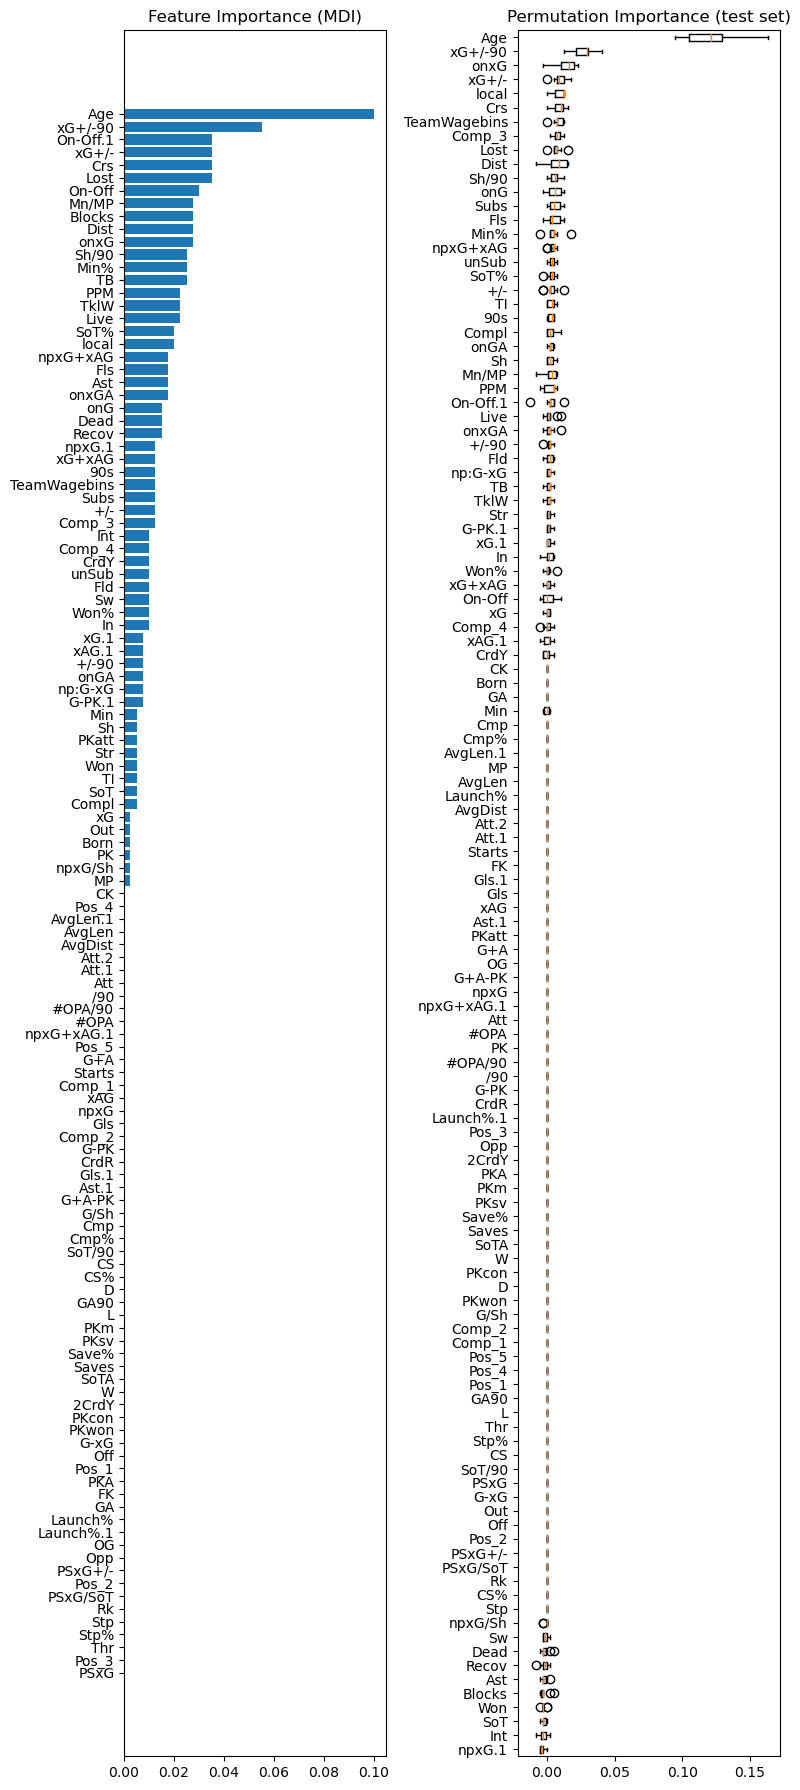

In [ ]:
feature_importance = ada_clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(8, 18))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    ada_clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(X.columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()